# BB84 QKD with QBER Estimation

This notebook implements the BB84 prepare-and-measure quantum key distribution protocol
end-to-end. It simulates Alice’s random bit and basis preparation, Bob’s random basis
measurements, basis reconciliation and sifting, and then computes the Quantum Bit Error Rate
(QBER) on a sampled subset of the sifted key to detect any potential eavesdropping.


## 1. Imports & Setup

In [30]:
%pip install qiskit
%pip install --upgrade typing_extensions
%pip install qiskit-aer
%pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
import secrets
import pathlib
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Simulator backend
backend = AerSimulator()
rng = secrets.SystemRandom()

## 2. Parameters

In [23]:
# User parameters
IMG_PATH        = pathlib.Path('download.png')
BLOCK_SIZE      = 10
ABORT_THRESHOLD = 0.11
SAMPLE_RATE     = 0.10

# Ensure image exists and read bytes
if not IMG_PATH.exists():
    raise FileNotFoundError(f'Missing {IMG_PATH}')

# Read the bytes from the image
img_bytes  = IMG_PATH.read_bytes()
n_img_bits = len(img_bytes) * 8
print(f"Image bits to secure: {n_img_bits}")

Image bits to secure: 30752


## 3. Utility Functions

In [24]:
# Random n bits generator
def random_bits(n):
    return np.random.randint(2, size=n, dtype=np.uint8)

# Return the Hamming distance (number of differing elements) between arrays a and b
def hamming(a,b): 
    return np.count_nonzero(a!=b)

# Turns bits into bytes using numpy
def bits_to_bytes(bits):
    arr    = np.array(bits, dtype=np.uint8)
    packed = np.packbits(arr)
    return packed.tobytes()

## 4. BB84 Emitter & Measurement Circuits

In [25]:
def alice_circuit(bits, bases):
    qc = QuantumCircuit(len(bits), name='Alice')
    for i,(bit,basis) in enumerate(zip(bits,bases)):
        if bit: qc.x(i)
        if basis: qc.h(i)
    return qc

def bob_measure(alice_qc, bob_bases):
    n = len(bob_bases)
    qc_bob = QuantumCircuit(n, n, name='Bob')
    for i,basis in enumerate(bob_bases):
        if basis: qc_bob.h(i)
        qc_bob.measure(i,i)
    full = alice_qc.compose(qc_bob)
    compiled = transpile(full, backend)
    result   = backend.run(compiled, shots=1).result()
    bitstr   = next(iter(result.get_counts()))
    return np.fromiter(map(int, bitstr[::-1]), dtype=np.uint8)

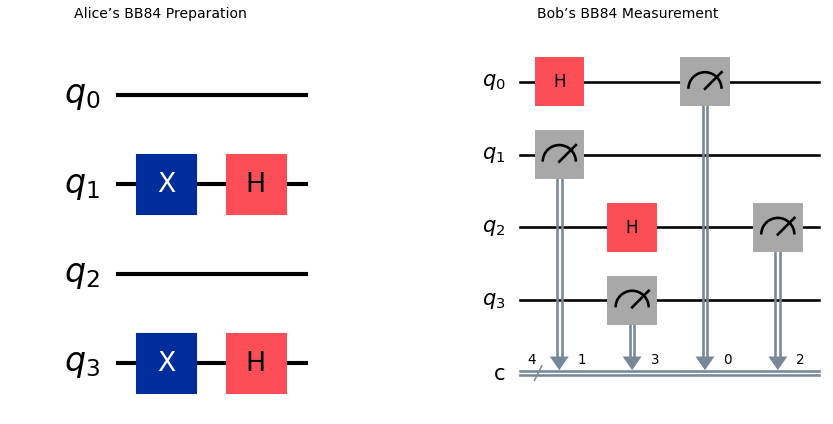

In [26]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

bits        = [0, 1, 0, 1]        
alice_bases = [0, 1, 0, 1]        
bob_bases   = [1, 0, 1, 0]       

qc_alice = alice_circuit(bits, alice_bases)

n = len(bob_bases)
qc_bob  = QuantumCircuit(n, n, name='Bob')
for i, basis in enumerate(bob_bases):
    if basis:
        qc_bob.h(i)
    qc_bob.measure(i, i)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

circuit_drawer(qc_alice, output='mpl', ax=ax1)
ax1.set_title("Alice’s BB84 Preparation", fontsize=14)

circuit_drawer(qc_bob, output='mpl', ax=ax2)
ax2.set_title("Bob’s BB84 Measurement", fontsize=14)

plt.tight_layout()
plt.show()

## 5. Run Protocol & Collect Data

In [29]:
alice_key = []
bob_key   = []
rounds    = 0

while len(alice_key) < n_img_bits:
    # Increments round count and generates random basis for each side
    rounds += 1
    data_A = random_bits(BLOCK_SIZE)
    bases_A = random_bits(BLOCK_SIZE)
    
    # Alice prepares qubits and Bob measures in his random bases
    qc = alice_circuit(data_A, bases_A)

    bases_B = random_bits(BLOCK_SIZE)
    meas_B  = bob_measure(qc, bases_B)

    # Sift: keep only bits where bases matched
    keep_mask = bases_A == bases_B
    sift_A    = data_A[keep_mask]
    sift_B    = meas_B[keep_mask]

    # Sample a subset to estimate QBER and abort if too high
    sample_mask = np.random.rand(len(sift_A)) < SAMPLE_RATE
    qber = hamming(sift_A[sample_mask], sift_B[sample_mask]) / max(1, sample_mask.sum())
    if qber > ABORT_THRESHOLD:
        raise RuntimeError(f'ABORT — QBER {qber:.2%} exceeds {ABORT_THRESHOLD:.0%}')
    
    # Remove sampled bits and keep only perfectly matching bits
    sift_A = sift_A[~sample_mask]
    sift_B = sift_B[~sample_mask]
    match  = sift_A == sift_B
    
    # Append to the raw key
    alice_key.extend(sift_A[match].tolist())
    bob_key  .extend(sift_B[match].tolist())
    
    if rounds % 10 == 0:
        print(f"Round {rounds}: collected {len(alice_key)} bits", end='\r')

alice_key = np.array(alice_key[:n_img_bits], dtype=np.uint8)
bob_key   = np.array(bob_key  [:n_img_bits], dtype=np.uint8)
print(f'\nKey done: {len(alice_key):,} bits')

Round 6850: collected 30727 bits
Key done: 30,752 bits


## 6. Encrypt & Decrypt Image

In [32]:
# Use the sifted key
key_bytes = bits_to_bytes(alice_key)
cipher    = bytes(m ^ k for m,k in zip(img_bytes, key_bytes))

# Bob decrypts
dec_bytes = bytes(c ^ k for c,k in zip(cipher, key_bytes))
dec_path  = IMG_PATH.with_stem(IMG_PATH.stem + '_decrypted')
dec_path.write_bytes(dec_bytes)

if dec_bytes == img_bytes:
    print("✅ Image encrypted and decrypted successfully!")

✅ Image encrypted and decrypted successfully!



## Security Demonstration – Detecting an Eavesdropper (Eve)

The BB84 protocol detects an **intercept‑resend eavesdropper** through the *quantum bit‑error rate* (QBER).

* Eve randomly chooses a basis for each qubit she intercepts.  
* Whenever she guesses the **wrong** basis (50 % of the time) she collapses the qubit into the wrong state.  
* Even if Bob later measures in the correct basis, the qubit is already disturbed and Bob’s result is wrong half of those times.  
* Overall **​25 % QBER** is introduced, well above any realistic abort threshold (often ≤ 11 %).

The following simulation confirms this and prints the QBER with and without Eve for 2 000 qubits.


In [7]:
import numpy as np
from math import isclose

def simulate_bb84(n_bits=2000, eavesdrop=False, rng=np.random.default_rng()):
    # 1. Alice's random bits & bases (0 = Z, 1 = X)
    alice_bits  = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
    alice_basis = rng.integers(0, 2, size=n_bits, dtype=np.uint8)

    # 2. Bob's random bases
    bob_basis   = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
    bob_bits    = np.zeros(n_bits, dtype=np.uint8)

    if not eavesdrop:
        # Honest channel (noise‑free)
        for i in range(n_bits):
            if bob_basis[i] == alice_basis[i]:
                bob_bits[i] = alice_bits[i]          # deterministic
            else:
                bob_bits[i] = rng.integers(0, 2)     # random (will be discarded)
    else:
        # Eve intercept‑resend
        eve_basis = rng.integers(0, 2, size=n_bits, dtype=np.uint8)
        for i in range(n_bits):
            # Eve measures
            if eve_basis[i] == alice_basis[i]:
                eve_bit = alice_bits[i]
            else:
                eve_bit = rng.integers(0, 2)

            # Eve resends qubit in her basis/state; Bob measures
            if bob_basis[i] == eve_basis[i]:
                bob_bits[i] = eve_bit
            else:
                bob_bits[i] = rng.integers(0, 2)

    # Sifting – keep only indices where bases matched
    keep = alice_basis == bob_basis
    if not np.any(keep):
        return np.nan  # no sifted bits (very unlikely for n_bits ≫ 1)

    qber = np.mean(alice_bits[keep] != bob_bits[keep])
    return qber

qber_clean = simulate_bb84(eavesdrop=False)
qber_eave  = simulate_bb84(eavesdrop=True)

print(f"QBER (no Eve):  {qber_clean*100:.2f} %")
print(f"QBER (with Eve): {qber_eave*100:.2f} %")

QBER (no Eve):  0.00 %
QBER (with Eve): 25.00 %



**Expected result**

```
QBER (no Eve):   0.00 %
QBER (with Eve): ~25.00 %
```

Any significant deviation above the background error rate (often a few %) signals Eve’s presence, so Alice and Bob abort the protocol.
